#  Actor–Critic

In Actor Critic Methods 

* The Critic estimates the value function of state or of state-action.

* The Actor selects the actions and controls the policy distribution using the values provided by Critic.

The Critic and Actor functions are parameterized by neural networks.

# Reference

Richard S. Sutton and Andrew G. Barto (2018). *Reinforcement Learning: An Introduction*. A Bradford Book, Cambridge, MA, USA.

## One-step Actor–Critic Algorithm


<img src="images/actor-critic.png" width=800 height=800 style="float: left"/>

### Modules and packages

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf

import gym

import warnings
warnings.filterwarnings("ignore")

print("TensorFlow {}".format(tf.__version__))

TensorFlow 2.0.0


### Actor Critic agent

In [2]:
class ACAgent(object):

    def __init__(self,  env, actor_model, actor_optimizer, critic_model, critic_optimizer):
        # parameters
        self.num_episodes = 1000
        self.gamma = 0.9  # discount rate        

        # environment
        self.env = env
        self.state_size = len(env.observation_space.low)
        self.action_size = env.action_space.n

        # actor model and optimizer
        self.actor_model = actor_model
        self.actor_optimizer = actor_optimizer
        
        # critic model and optimizer
        self.critic_model = critic_model
        self.critic_optimizer = critic_optimizer

        # stats
        self.stats = {'rewards': []}
        self.show_stats = 200  # negative - not to show; positive - show specific episode
        self.show_episode = -1  # negative - not to show; positive - show specific episode
        
        self.I = 1. # see algorithm above

    def execute(self):        

        # for each episode
        for episode in range(1, self.num_episodes + 1):
            # init episode stats
            self.stats['rewards'].append(0)
            
            # get initial state
            state = self.env.reset()
            
            self.I = 1.

            # generate episode
            while True:

                # actor select action based on action probabilities
                action = self.select_action(state)

                # carry out action, observe new state and reward
                new_state, reward, done, _ = self.env.step(action)

                # one hot encoding of action
                action_one_hot = [0] * self.action_size
                action_one_hot[action] = 1

                # train 
                self.train(state, action_one_hot, new_state, reward, done)
                
                # update episode statistics
                self.stats['rewards'][-1] += reward

                # decide whether to continue episode
                if done:
                    break
                else:  # update state
                    state = new_state
                    self.I *= self.gamma

            # print stats on screen
            if self.show_stats > 0 and episode % self.show_stats == 0:
                print("episode: {}   reward: {}".format(episode,  self.stats['rewards'][-1]))

            # show simulated environment with learned parameters
            if self.show_episode > 0 and episode % self.show_episode == 0:
                self.act()

    def train(self, state_, action_one_hot, new_state_, reward, done):
        
        # convert to array and tensor formats        
        new_state = np.array(new_state_, dtype=np.float32).reshape(1,-1)   
        
        state = tf.convert_to_tensor([state_], dtype=np.float32) 
        action = tf.convert_to_tensor([action_one_hot], dtype=np.float32)
        
        # critic estimates V_new
        new_value = reward + (1 - done) * self.gamma * self.critic_model.predict(new_state)[0][0]
        
        # UPDATE CRITIC MODEL        
        with tf.GradientTape() as tape:
            # critic estimates V
            value = self.critic_model(state)
            
            # estimated advantage of the taken action 
            delta = new_value - value.numpy()[0][0]
            
            # critic's loss
            critic_loss = - delta * value

        # Get the gradients
        critic_variables = self.critic_model.trainable_variables
        critic_gradients = tape.gradient(critic_loss, critic_variables)
        
        # Update the weights
        self.critic_optimizer.apply_gradients(zip(critic_gradients, critic_variables))
        
        
        # UPDATE ACTOR        
        with tf.GradientTape() as tape:
            # probability of taken action
            prob = self.actor_model(state)
            prob = tf.reduce_sum(action * prob)
            
            # log probability         
            log_prob = tf.math.log(prob)
            
            # loss function 
            actor_loss = - log_prob * delta * self.I

        # Get the gradients
        actor_variables = self.actor_model.trainable_variables
        actor_gradients = tape.gradient(actor_loss, actor_variables)
        
        # Update the weights
        self.actor_optimizer.apply_gradients(zip(actor_gradients, actor_variables))
        

    # select action based on action probabilities
    def select_action(self, state):
        probabilities = self.actor_model.predict(np.array(state).reshape(1, -1)).flatten()
        action = np.random.choice(range(self.action_size), 1, p=probabilities)
        return action[0]

    def act(self):
        total_reward = 0
        state = self.env.reset()
        done = False
        while not done:
            action = self.select_action(state)
            state, reward, done, _ = self.env.step(action)
            total_reward += reward
            self.env.render()
        self.env.close()
        return total_reward

### Neural networks parameterizing policy and value functions

In [3]:
def build_actor_model(state_size, action_size):
    
    # computaion graph
    x = tf.keras.layers.Input(shape=(state_size,))
    h = tf.keras.layers.Dense(32, activation='relu')(x)
    y = tf.keras.layers.Dense(action_size, activation='softmax')(h)

    # model and optimizer
    model = tf.keras.models.Model(inputs=x, outputs=y)
    optimizer = tf.optimizers.Adam(lr=0.0001)
    
    return model, optimizer

def build_critic_model(state_size):
    
    # computaion graph
    x = tf.keras.layers.Input(shape=(state_size,))
    h = tf.keras.layers.Dense(32, activation='relu')(x)
    y = tf.keras.layers.Dense(1, activation='linear')(h)

    # model and optimizer
    model = tf.keras.models.Model(inputs=x, outputs=y)
    optimizer = tf.optimizers.Adam(lr=0.001)
    
    return model, optimizer

### Example

In [4]:
env = gym.make("CartPole-v0")

state_size = len(env.observation_space.low)
action_size = env.action_space.n

actor_model, actor_optimizer = build_actor_model(state_size, action_size) 
critic_model, critic_optimizer = build_critic_model(state_size) 

agent = ACAgent(env, actor_model, actor_optimizer, critic_model, critic_optimizer)
agent.execute()
agent.act()

episode: 200   reward: 40.0
episode: 400   reward: 74.0
episode: 600   reward: 99.0
episode: 800   reward: 200.0
episode: 1000   reward: 200.0


200.0

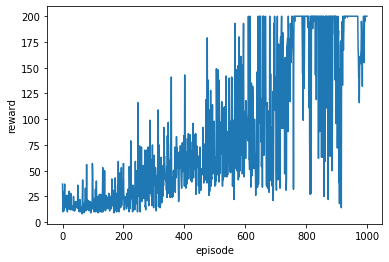

In [5]:
plt.plot(agent.stats['rewards'])
plt.xlabel('episode')
plt.ylabel('reward')
plt.show()